In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

import adaptivealgo.cli.policy_iter as pi

Finding policy for n_links=2 converged in 2 iterations
Finding policy for n_links=3 converged in 2 iterations
Finding policy for n_links=4 converged in 2 iterations
Finding policy for n_links=5 converged in 3 iterations


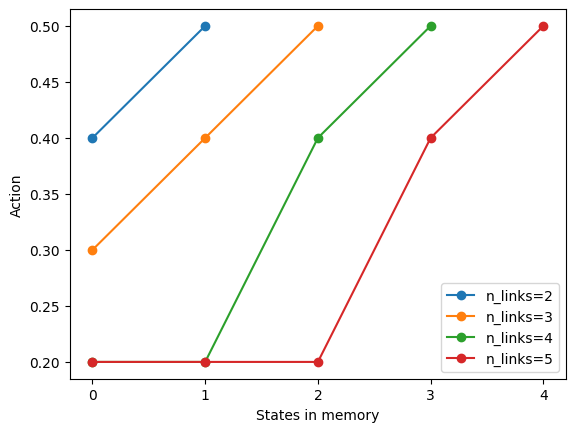

In [2]:
links = [2, 3, 4, 5]
f_thresh = 0.4
actions = [0.1, 0.2, 0.3, 0.4, 0.5]
alpha = 1.0
gamma = 0.2
tol = 1e-6

policies = {}
for n_links in links:
    policy, i = pi.find_policy(n_links, f_thresh, actions, alpha, gamma, tol)
    policies[n_links] = policy["policy"]
    print(f"Finding policy for n_links={n_links} converged in {i} iterations")

all_actions = {}

for n_links, policy in policies.items():
    all_actions[n_links] = {}
    for state, action in policy.items():
        state_list = json.loads(state)
        state_length = len(state_list)
        if state_length not in all_actions[n_links]:
            all_actions[n_links][state_length] = []
        all_actions[n_links][state_length].append(action)

mc_actions = {}

for n_links, policy in all_actions.items():
    for state_length, state_actions in policy.items():
        mc_action_idx = max(set(state_actions), key=state_actions.count)
        if n_links not in mc_actions:
            mc_actions[n_links] = {}
        mc_actions[n_links][state_length] = actions[mc_action_idx]

for n_links, policy in mc_actions.items():
    x = list(policy.keys())
    y = list(policy.values())
    plt.plot(x, y, label=f"n_links={n_links}", marker='o')

plt.xlabel("States in memory")
plt.ylabel("Action")
plt.xticks(np.arange(0, max(mc_actions.keys()), 1))
plt.legend()
    

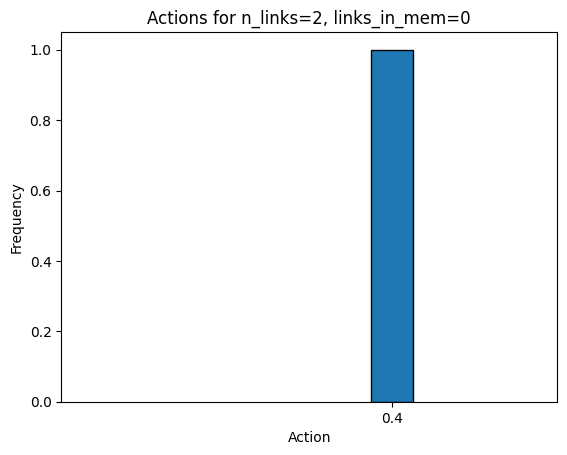

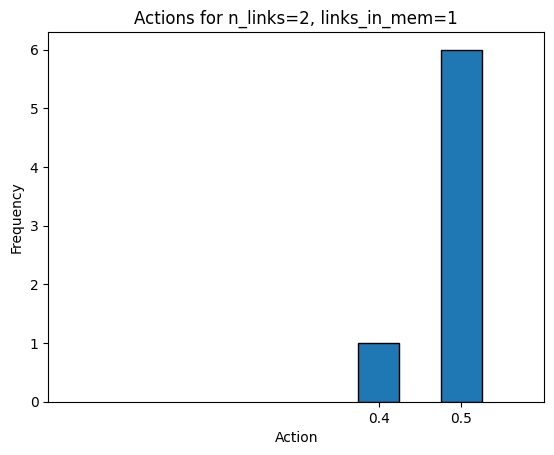

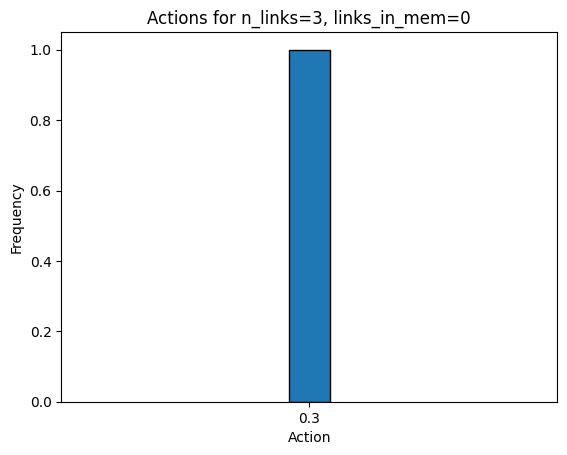

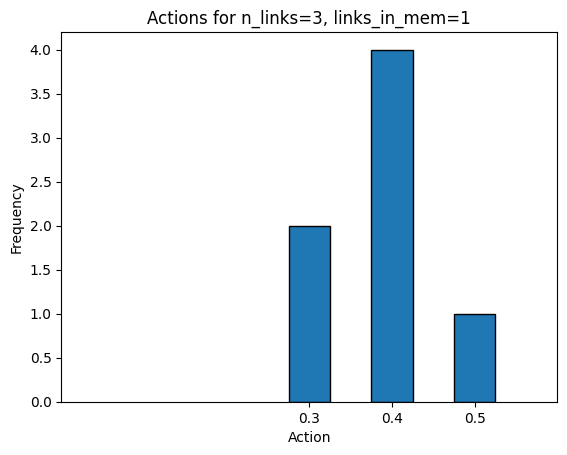

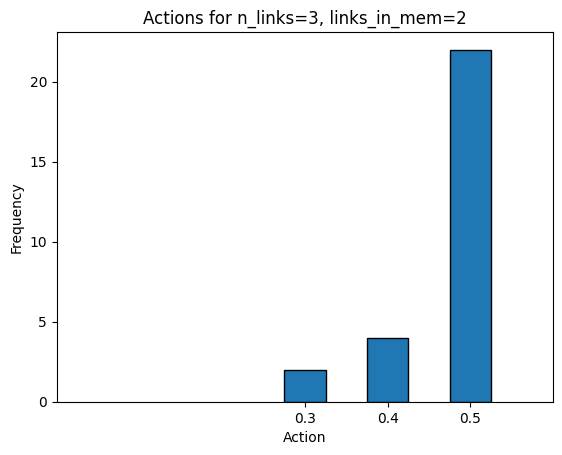

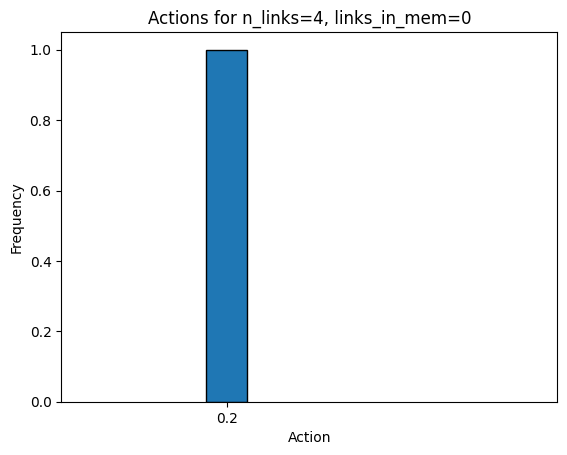

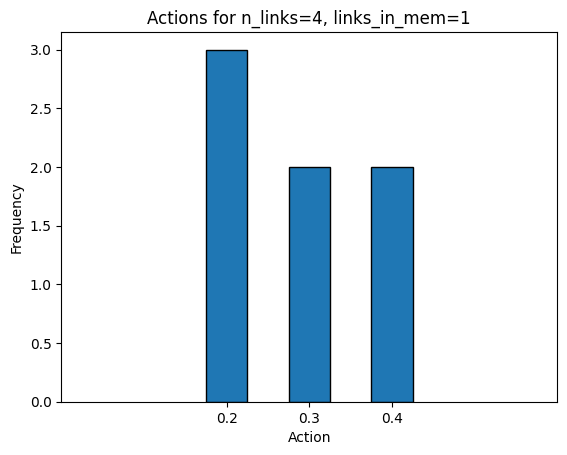

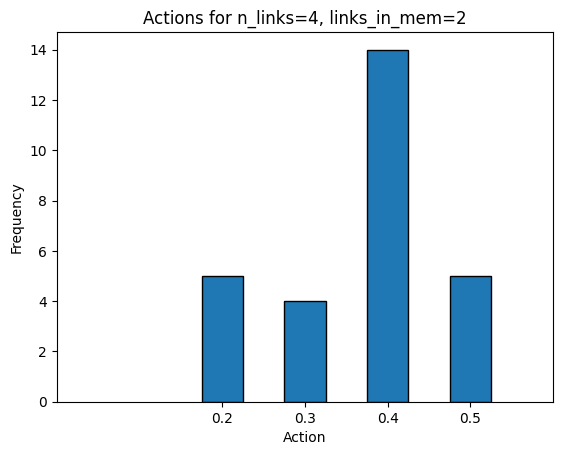

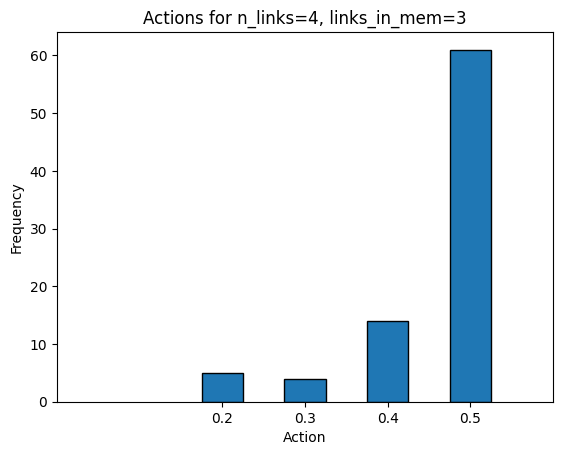

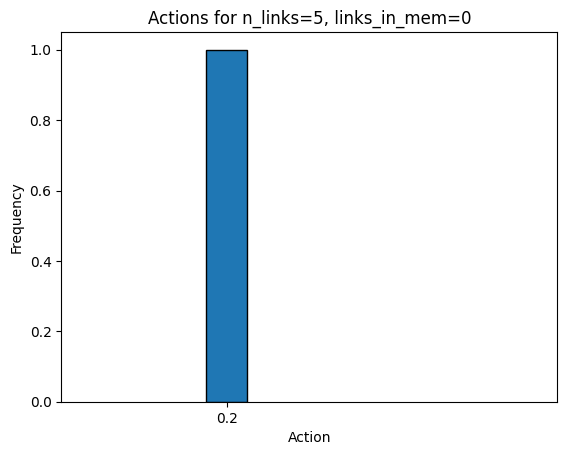

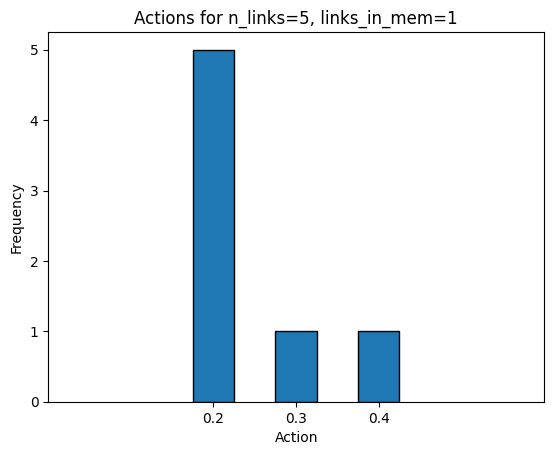

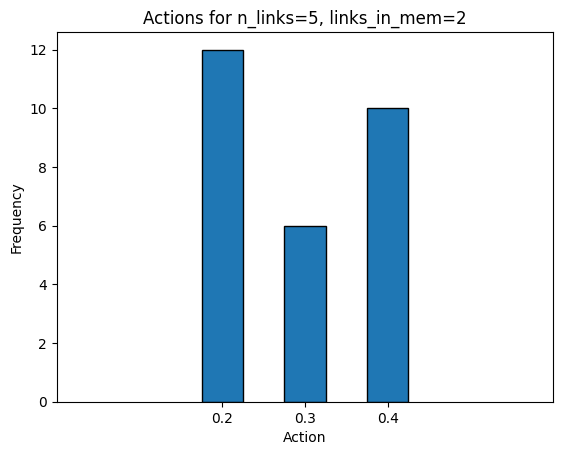

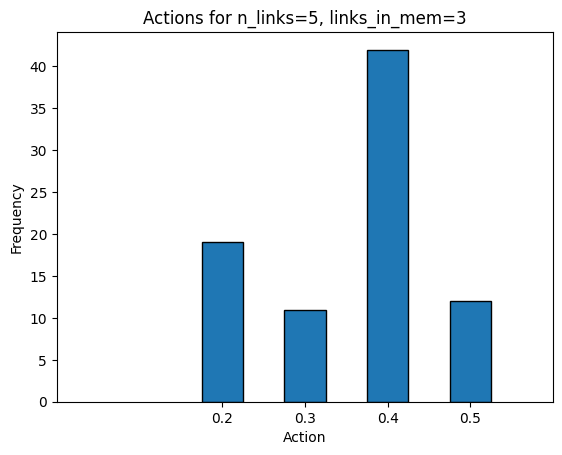

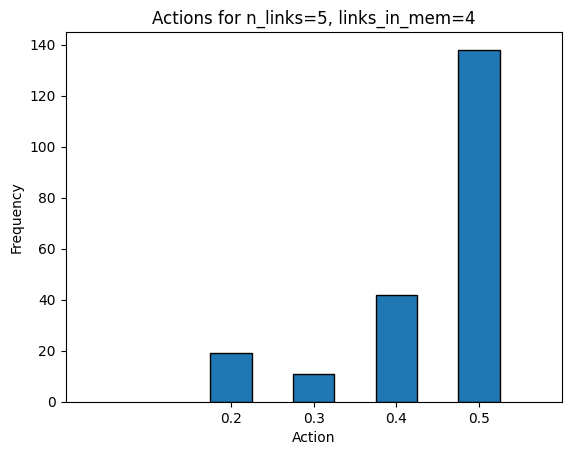

In [6]:
for n_links, policy in all_actions.items():
    for state_length, actions_idxs in policy.items():
        state_actions = [actions[idx] for idx in actions_idxs]
        plt.figure()
        labels, counts = np.unique(state_actions, return_counts=True)
        plt.bar(labels, counts, align='center', width=0.05, edgecolor='black')
        plt.gca().set_xticks(labels)
        plt.gca().set_xticklabels(labels)
        plt.gca().set_xbound(min(actions) - 0.1, max(actions) + 0.1)
        plt.xlabel(f"Action")
        plt.ylabel("Frequency")
        plt.title(f"Actions for n_links={n_links}, links_in_mem={state_length}")
        plt.show()